# Analytical examples demonstrating the issue

The aim of this notebook is to demonstrate with simple analytical examples that the currently proposed TMC (Transformer Monte Carlo) integration can fail under certain circumstances. 
The current TMC (faulty) proposal is available [here](https://gitlab.com/francesco-calcavecchia/transformer-monte-carlo-paper/-/tree/23f3e38d73645c5f10674010c0fa634314d6a50d).

In [4]:
 var('x', 'y', 'z', 'q')

(x, y, z, q)

In [5]:
k = 1

## Example in 1D

In [6]:
rho = exp(-x^2) / sqrt(pi)
g = cos(k*x)

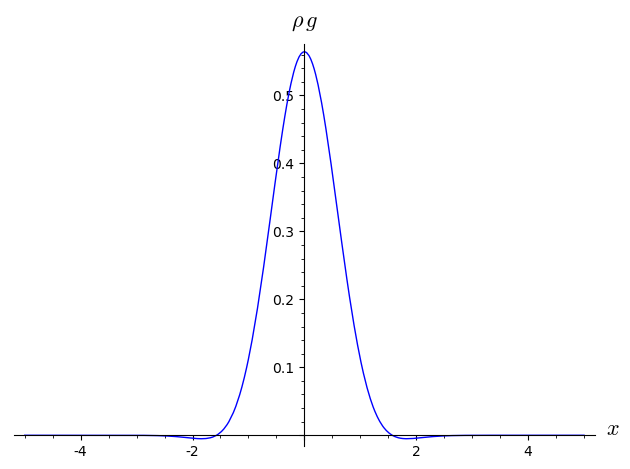

In [7]:
plot(rho*g, (x, -5, 5), axes_labels=[r'$x$', r'$\rho \, g$'])

In [8]:
def compute_integral(a, b, rho, g):
    return integrate(rho * g, x, a, b)

In [9]:
def compute_mcmc_variance(a, b, rho, g):
    return (compute_integral(a, b, 1, rho * g^2) - (compute_integral(a, b, rho, g))^2)

In [52]:
def print_mcmc_info(a, b, rho, g, variance=True):
    print('MCMC Integral: {}'.format(float(compute_integral(a, b, rho, g))))
    if variance:
        print('MCMC Variance: {}'.format(float(compute_mcmc_variance(a, b, rho, g))))

As first thing, let's compute the correct integral.

In [11]:
print_mcmc_info(-oo, oo, rho, g)

MCMC Integral: 0.7788007830714049
MCMC Variance: 0.07740906087308774


We then use TMC with the following transformation

In [53]:
t = -x

and equal weights $\alpha_0 = \alpha_1 = \frac{1}{2}$:

In [54]:
print_mcmc_info(-oo, 
                oo, 
                rho,  
                0.5 * g + 0.5 * (rho(t) / rho) * g(t) * jacobian(t, (x)).determinant())

MCMC Integral: 0.0
MCMC Variance: 0.0


Despite its innocent-looking, the transformation $ t(x) = -x $ leads to a wrong result.

The reason for this, is that $\frac{\rho(t(X))}{\rho(X)} = 1$, $g(t(X)) = g(X)$, and $\det(J_t)(X) = 1$. This demonstrate that our formulation did not account for a factor.

Indeed we did a mistake due to our simplification of the notation. In formula (2) the domain of the integral would be $t^{-1}(\Omega)$. In this specific case, where $\Omega = (-\infty, +\infty)$, it would correspond to the inverted range, i.e. $t^{-1}(\Omega) = (+\infty, -\infty)$, which flips the sign of the integral. 
In fact, if we insert this corrected sign in the equation (3), we obtain

In [55]:
print_mcmc_info(-oo, 
                oo, 
                rho,  
                0.5 * g - 0.5 * (rho(t) / rho) * g(t) * jacobian(t, (x)).determinant())

MCMC Integral: 0.7788007830714049
MCMC Variance: 0.07740906087308774


the original integral result, as expected.

Notice that the problem affects only the sign of the transformed integral, not the absolute value. For example, if we take some more "creative" transformations

In [58]:
t = -x/3

In [59]:
print_mcmc_info(-oo, 
                oo, 
                rho,  
                0.5 * g + 0.5 * (rho(t) / rho) * g(t) * jacobian(t, (x)).determinant(),
                variance=False)

MCMC Integral: 0.0


In [60]:
t = -x*x*x

In [61]:
print_mcmc_info(-oo, 
                oo, 
                rho,  
                0.5 * g + 0.5 * (rho(t) / rho) * g(t) * jacobian(t, (x)).determinant(),
                variance=False)

MCMC Integral: 0.0


Notice that if we break the requirement of $t$ being a bijection, we can incur into unwanted results

In [64]:
t = -x*x

In [65]:
print_mcmc_info(-oo, 
                oo, 
                rho,  
                0.5 * g + 0.5 * (rho(t) / rho) * g(t) * jacobian(t, (x)).determinant(),
                variance=False)

MCMC Integral: 0.38940039153570244


## Example in 2D

In [11]:
rho_2d = lambda x, y: exp(-x^2-y^2) / sqrt(pi)
g_2d = lambda x, y: cos(k * x + k * y)

In [12]:
def compute_2d_integral(a, b, rho, g):
    return integrate(integrate(rho * g, x, a[0], b[0]), y, a[1], b[1])

In [13]:
def compute_2d_numerical_integral(a, b, rho, g):
    return numerical_integral(numerical_integral(rho * g, x, a[0], b[0]), y, a[1], b[1])

In [14]:
def print_2d_mcmc_info(a, b, rho, g):
    print('MCMC 2D Integral: {}'.format(float(compute_2d_integral(a, b, rho, g))))

The original integral leads to

In [15]:
print_2d_mcmc_info([-oo, -oo], 
                   [oo, oo], 
                   rho_2d(x, y), 
                   g_2d(x, y))

MCMC 2D Integral: 1.0750476034999201


Now let us look at 4 possible transformations $t$, and what happens to the right-hand side integral of equation (3), i.e. the integral after the $\alpha_1$ factor.

In [16]:
t_2d = lambda x, y: (x, y)

In [17]:
print_2d_mcmc_info([-oo, -oo], 
                   [oo, oo], 
                   rho_2d(x, y), 
                   (rho_2d(*t_2d(x, y)) / rho_2d(x, y)) 
                    * g_2d(*t_2d(x, y)) 
                    * (jacobian(t_2d(x, y), (x, y)).determinant()))


MCMC 2D Integral: 1.0750476034999201


In [18]:
t_2d = lambda x, y: (-x, -y)

In [19]:
print_2d_mcmc_info([-oo, -oo], 
                   [oo, oo], 
                   rho_2d(x, y), 
                   (rho_2d(*t_2d(x, y)) / rho_2d(x, y)) 
                    * g_2d(*t_2d(x, y)) 
                    * (jacobian(t_2d(x, y), (x, y)).determinant()))

MCMC 2D Integral: 1.0750476034999201


In [20]:
t_2d = lambda x, y: (-x, y)

In [21]:
print_2d_mcmc_info([-oo, -oo], 
                   [oo, oo], 
                   rho_2d(x, y), 
                   (rho_2d(*t_2d(x, y)) / rho_2d(x, y)) 
                    * g_2d(*t_2d(x, y)) 
                    * (jacobian(t_2d(x, y), (x, y)).determinant()))

MCMC 2D Integral: -1.0750476034999201


In [22]:
t_2d = lambda x, y: (x, -y)

In [23]:
print_2d_mcmc_info([-oo, -oo], 
                   [oo, oo], 
                   rho_2d(x, y), 
                   (rho_2d(*t_2d(x, y)) / rho_2d(x, y)) 
                    * g_2d(*t_2d(x, y)) 
                    * (jacobian(t_2d(x, y), (x, y)).determinant()))

MCMC 2D Integral: -1.0750476034999201


In the cases $t = x, y \mapsto x, y$ and $t = x, y \mapsto -x, -y$, the integral is equivalent to the original one.

In the cases $t = x, y \mapsto -x, y$ and $t = x, y \mapsto x, -y$, the integral is minus the original integral.

## Example in 3D

In [15]:
rho_3d = lambda x, y, z: exp(-x^2-y^2-z^2) / sqrt(pi)
g_3d = lambda x, y, z: cos(k * x + k * y + k * z)

In [16]:
def compute_3d_integral(a, b, rho, g):
    return integrate(integrate(integrate(rho * g, x, a[0], b[0]), y, a[1], b[1]), z, a[2], b[2])

In [17]:
def print_3d_mcmc_info(a, b, rho, g):
    print('MCMC 3D Integral: {}'.format(float(compute_3d_integral(a, b, rho, g))))

The original integral

In [18]:
print_3d_mcmc_info([-oo, -oo, -oo], 
                   [oo, oo, oo], 
                   rho_3d(x, y, z), 
                   g_3d(x, y, z))

MCMC 3D Integral: 1.4839832918927074


Let us now look at some possible transformations, and at the transformed integral (integral factorized by $\alpha_1$ in eq. (3)).

In [19]:
t_3d = lambda x, y, z: (x, y, z)

In [20]:
print_3d_mcmc_info([-oo, -oo, -oo], 
                   [oo, oo, oo], 
                   rho_3d(x, y, z), 
                   (rho_3d(*t_3d(x, y, z)) / rho_3d(x, y, z)) 
                    * g_3d(*t_3d(x, y, z)) 
                    * (jacobian(t_3d(x, y, z), (x, y, z)).determinant()))

MCMC 3D Integral: 1.4839832918927074


In [21]:
t_3d = lambda x, y, z: (-x, y, z)

In [22]:
print_3d_mcmc_info([-oo, -oo, -oo], 
                   [oo, oo, oo], 
                   rho_3d(x, y, z), 
                   (rho_3d(*t_3d(x, y, z)) / rho_3d(x, y, z)) 
                    * g_3d(*t_3d(x, y, z)) 
                    * (jacobian(t_3d(x, y, z), (x, y, z)).determinant()))

MCMC 3D Integral: -1.4839832918927074


In [23]:
t_3d = lambda x, y, z: (x, -y, z)

In [24]:
print_3d_mcmc_info([-oo, -oo, -oo], 
                   [oo, oo, oo], 
                   rho_3d(x, y, z), 
                   (rho_3d(*t_3d(x, y, z)) / rho_3d(x, y, z)) 
                    * g_3d(*t_3d(x, y, z)) 
                    * (jacobian(t_3d(x, y, z), (x, y, z)).determinant()))

MCMC 3D Integral: -1.4839832918927074


In [25]:
t_3d = lambda x, y, z: (x, y, -z)

In [26]:
print_3d_mcmc_info([-oo, -oo, -oo], 
                   [oo, oo, oo], 
                   rho_3d(x, y, z), 
                   (rho_3d(*t_3d(x, y, z)) / rho_3d(x, y, z)) 
                    * g_3d(*t_3d(x, y, z)) 
                    * (jacobian(t_3d(x, y, z), (x, y, z)).determinant()))

MCMC 3D Integral: -1.4839832918927074


In [27]:
t_3d = lambda x, y, z: (-x, -y, z)

In [28]:
print_3d_mcmc_info([-oo, -oo, -oo], 
                   [oo, oo, oo], 
                   rho_3d(x, y, z), 
                   (rho_3d(*t_3d(x, y, z)) / rho_3d(x, y, z)) 
                    * g_3d(*t_3d(x, y, z)) 
                    * (jacobian(t_3d(x, y, z), (x, y, z)).determinant()))

MCMC 3D Integral: 1.4839832918927074


In [29]:
t_3d = lambda x, y, z: (-x, y, -z)

In [30]:
print_3d_mcmc_info([-oo, -oo, -oo], 
                   [oo, oo, oo], 
                   rho_3d(x, y, z), 
                   (rho_3d(*t_3d(x, y, z)) / rho_3d(x, y, z)) 
                    * g_3d(*t_3d(x, y, z)) 
                    * (jacobian(t_3d(x, y, z), (x, y, z)).determinant()))

MCMC 3D Integral: 1.4839832918927074


In [31]:
t_3d = lambda x, y, z: (x, -y, -z)

In [32]:
print_3d_mcmc_info([-oo, -oo, -oo], 
                   [oo, oo, oo], 
                   rho_3d(x, y, z), 
                   (rho_3d(*t_3d(x, y, z)) / rho_3d(x, y, z)) 
                    * g_3d(*t_3d(x, y, z)) 
                    * (jacobian(t_3d(x, y, z), (x, y, z)).determinant()))

MCMC 3D Integral: 1.4839832918927074


In [33]:
t_3d = lambda x, y, z: (-x, -y, -z)

In [34]:
print_3d_mcmc_info([-oo, -oo, -oo], 
                   [oo, oo, oo], 
                   rho_3d(x, y, z), 
                   (rho_3d(*t_3d(x, y, z)) / rho_3d(x, y, z)) 
                    * g_3d(*t_3d(x, y, z)) 
                    * (jacobian(t_3d(x, y, z), (x, y, z)).determinant()))

MCMC 3D Integral: -1.4839832918927074


In the cases where we flip the sign of an even number of coordinates (including 0), we obtain the original integral.

In the cases where we flip the sign of an odd number of coordinates, we obtain minus the original integral.

Also in this case, as in 1D, it is easy to show that the error occurs only in the sign, not in the absolute value of the integral. For example:

In [39]:
t_3d = lambda x, y, z: (-0.5*x, -0.5*y, -3.*z)

In [40]:
print_3d_mcmc_info([-oo, -oo, -oo], 
                   [oo, oo, oo], 
                   rho_3d(x, y, z), 
                   (rho_3d(*t_3d(x, y, z)) / rho_3d(x, y, z)) 
                    * g_3d(*t_3d(x, y, z)) 
                    * (jacobian(t_3d(x, y, z), (x, y, z)).determinant()))

MCMC 3D Integral: -1.4839832918927074


## Conclusion

We have demonstrated with few simple examples that the current formulation of TMC can incur in a problem that can cause the wrong sign to appear in one of the transformed integrals.

Furthermore, we have showed that the issue affects only the sign of the transformed integral, not its absolute value.